### Concurrent Neural Network CNN with data augmentation

#### TF-Keras

##### Dataset CIFAR10

#### PART A - Base Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import Sequential
from tensorflow.keras import backend
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report

np.random.seed(7)

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

##### Load Data

In [2]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [4]:
cat_dict = {
    0: 'Plane',
    1: 'Car',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Boat',
    9: 'Truck',
}

y_train_cat = pd.Series(y_train.flatten()).map(cat_dict)
y_test_cat = pd.Series(y_test.flatten()).map(cat_dict)

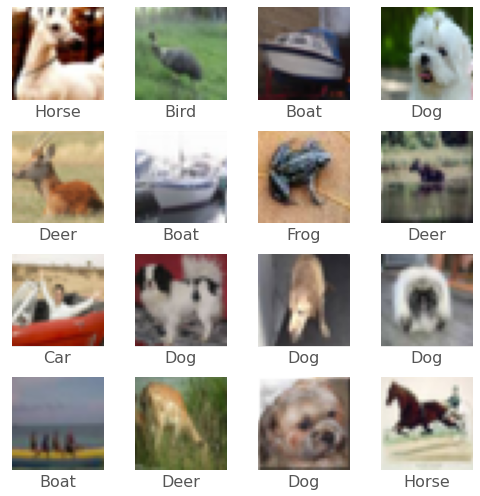

In [5]:
idxs = np.random.randint(low=0, high=len(X_train), size=16)

plt.figure(figsize=(7, 7))
for k, idx in enumerate(idxs):
    plt.subplot(4, 4, k+1)
    plt.imshow(X_train[idx])
    plt.xlabel(y_train_cat[idx], fontsize=16)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [6]:
# Scaling images [0, 255] -> [0, 1]
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train / 255
X_test = X_test / 255

In [7]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

##### CNN Architecture

In [8]:
def create_model(input_shp):
    
    backend.clear_session()
    
    model = Sequential()
    
    model.add(InputLayer(input_shape=input_shp))
    
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    return model

In [9]:
model = create_model(X_train[0].shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                        

In [10]:
optimizer = SGD(learning_rate=0.001, momentum=0.9)

model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

##### Training

In [11]:
epochs=500
patience = int(0.1*epochs)
tol = 1e-10
batch = 64

In [12]:
# Callback
es = EarlyStopping(
    monitor='val_loss',
    min_delta=tol,
    patience=patience,
    verbose=2,
    mode='min',
    restore_best_weights=True,
)

In [13]:
# Fit
hist = model.fit(
    x=X_train, y=y_train,
    batch_size=batch,
    validation_split=0.2,
    epochs=epochs,
    callbacks=es,
    verbose=1,
)

Epoch 1/500
625/625 [==============================] - 13s 14ms/step - loss: 2.2858 - accuracy: 0.1317 - val_loss: 2.1487 - val_accuracy: 0.2013
Epoch 2/500
625/625 [==============================] - 9s 15ms/step - loss: 2.0480 - accuracy: 0.2349 - val_loss: 1.8645 - val_accuracy: 0.3584
Epoch 3/500
625/625 [==============================] - 9s 15ms/step - loss: 1.8498 - accuracy: 0.3080 - val_loss: 1.6883 - val_accuracy: 0.3837
Epoch 4/500
625/625 [==============================] - 9s 15ms/step - loss: 1.7356 - accuracy: 0.3517 - val_loss: 1.6171 - val_accuracy: 0.4142
Epoch 5/500
625/625 [==============================] - 9s 15ms/step - loss: 1.6630 - accuracy: 0.3862 - val_loss: 1.5452 - val_accuracy: 0.4390
Epoch 6/500
625/625 [==============================] - 9s 15ms/step - loss: 1.6039 - accuracy: 0.4085 - val_loss: 1.4739 - val_accuracy: 0.4677
Epoch 7/500
625/625 [==============================] - 9s 15ms/step - loss: 1.5514 - accuracy: 0.4277 - val_loss: 1.4692 - val_accuracy

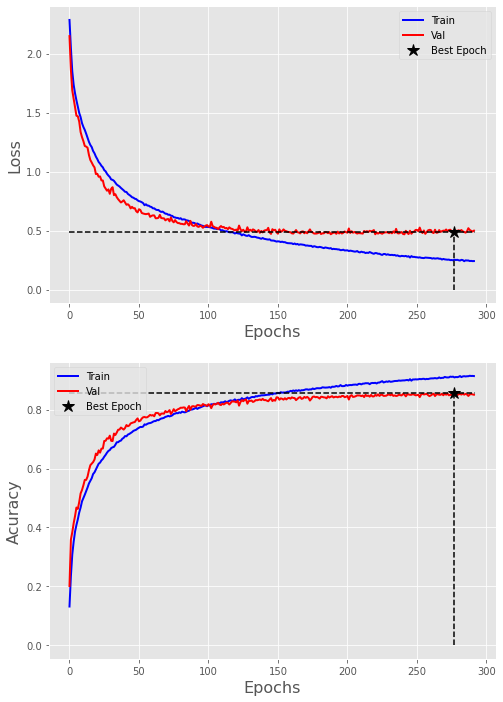

In [14]:
best_epoch = np.argmax(hist.history['val_accuracy'])

plt.figure(figsize=(8, 12))

plt.subplot(211)


plt.plot(hist.history['loss'], c='blue', linewidth=2, label='Train')
plt.plot(hist.history['val_loss'], c='red', linewidth=2, label='Val')
plt.plot(best_epoch, hist.history['val_loss'][best_epoch], '*', c='k', markersize=12, label='Best Epoch')
plt.hlines(hist.history['val_loss'][best_epoch], 0, len(hist.history['val_loss']), linestyles='--', colors='k')
plt.vlines(best_epoch, 0, hist.history['val_loss'][best_epoch], linestyles='--', colors='k')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend()
plt.grid(True)

plt.subplot(212)
plt.plot(hist.history['accuracy'], c='blue', linewidth=2, label='Train')
plt.plot(hist.history['val_accuracy'], c='red', linewidth=2, label='Val')
plt.plot(best_epoch, hist.history['val_accuracy'][best_epoch], '*', c='k', markersize=12, label='Best Epoch')
plt.hlines(hist.history['val_accuracy'][best_epoch], 0, len(hist.history['val_accuracy']), linestyles='--', colors='k')
plt.vlines(best_epoch, 0, hist.history['val_accuracy'][best_epoch], linestyles='--', colors='k')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Acuracy', fontsize=16)
plt.legend()
plt.grid(True)

plt.show()

##### Testing

In [15]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

313/313 [==============================] - 2s 7ms/step - loss: 0.5069 - accuracy: 0.8419
Test loss: 0.5068555474281311
Test accuracy: 0.8418999910354614


In [16]:
y_pred_A = model.predict(X_test)
y_pred_A = np.argmax(y_pred_A, axis=1)

y_test_metric = np.argmax(y_test, axis=1)

In [17]:
print(classification_report(y_test_metric, y_pred_A))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1000
           1       0.93      0.90      0.92      1000
           2       0.80      0.75      0.78      1000
           3       0.72      0.70      0.71      1000
           4       0.80      0.85      0.82      1000
           5       0.81      0.73      0.77      1000
           6       0.86      0.91      0.88      1000
           7       0.89      0.87      0.88      1000
           8       0.88      0.93      0.91      1000
           9       0.87      0.92      0.89      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



#### Part B: Data Augmentation

In [18]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255
X_test = X_test / 255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [19]:
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2)

datagen.fit(X_train)

In [20]:
data_train = datagen.flow(X_train, y_train, batch_size=64)

(64, 32, 32, 3) (64, 10)


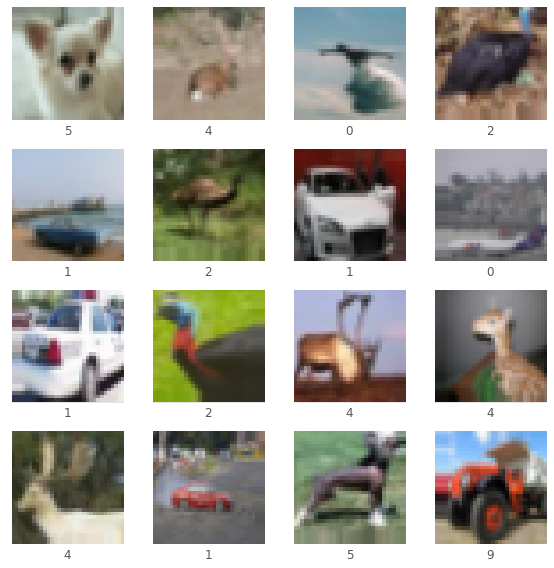

In [21]:
imgs, labels = data_train.next()

print(imgs.shape, labels.shape)

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(imgs[i])
    plt.xlabel(np.argmax(labels[i], axis=0))
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

##### Retrain Model

In [22]:
model = create_model(X_train[0].shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                        

In [23]:
model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

In [24]:
hist = model.fit(datagen.flow(X_train, y_train, batch_size=64, subset='training'),
         validation_data=datagen.flow(X_train, y_train, batch_size=12, subset='validation'),
         epochs=epochs,
         callbacks=es,
         verbose=1
         )

Epoch 1/500
625/625 [==============================] - 27s 41ms/step - loss: 2.2025 - accuracy: 0.1690 - val_loss: 2.0372 - val_accuracy: 0.2552
Epoch 2/500
625/625 [==============================] - 25s 40ms/step - loss: 1.9977 - accuracy: 0.2459 - val_loss: 1.8414 - val_accuracy: 0.3308
Epoch 3/500
625/625 [==============================] - 25s 41ms/step - loss: 1.8607 - accuracy: 0.2933 - val_loss: 1.7347 - val_accuracy: 0.3506
Epoch 4/500
625/625 [==============================] - 25s 39ms/step - loss: 1.7729 - accuracy: 0.3287 - val_loss: 1.6607 - val_accuracy: 0.3723
Epoch 5/500
625/625 [==============================] - 25s 39ms/step - loss: 1.7030 - accuracy: 0.3559 - val_loss: 1.6131 - val_accuracy: 0.4072
Epoch 6/500
625/625 [==============================] - 25s 40ms/step - loss: 1.6419 - accuracy: 0.3839 - val_loss: 1.5519 - val_accuracy: 0.4293
Epoch 7/500
625/625 [==============================] - 25s 39ms/step - loss: 1.5954 - accuracy: 0.4061 - val_loss: 1.4623 - val_ac

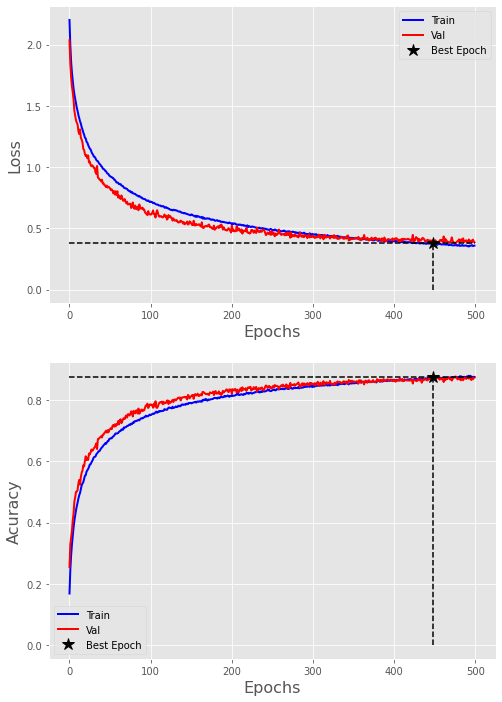

In [25]:
best_epoch = np.argmax(hist.history['val_accuracy'])

plt.figure(figsize=(8, 12))

plt.subplot(211)


plt.plot(hist.history['loss'], c='blue', linewidth=2, label='Train')
plt.plot(hist.history['val_loss'], c='red', linewidth=2, label='Val')
plt.plot(best_epoch, hist.history['val_loss'][best_epoch], '*', c='k', markersize=12, label='Best Epoch')
plt.hlines(hist.history['val_loss'][best_epoch], 0, len(hist.history['val_loss']), linestyles='--', colors='k')
plt.vlines(best_epoch, 0, hist.history['val_loss'][best_epoch], linestyles='--', colors='k')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend()
plt.grid(True)

plt.subplot(212)
plt.plot(hist.history['accuracy'], c='blue', linewidth=2, label='Train')
plt.plot(hist.history['val_accuracy'], c='red', linewidth=2, label='Val')
plt.plot(best_epoch, hist.history['val_accuracy'][best_epoch], '*', c='k', markersize=12, label='Best Epoch')
plt.hlines(hist.history['val_accuracy'][best_epoch], 0, len(hist.history['val_accuracy']), linestyles='--', colors='k')
plt.vlines(best_epoch, 0, hist.history['val_accuracy'][best_epoch], linestyles='--', colors='k')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Acuracy', fontsize=16)
plt.legend()
plt.grid(True)

plt.show()

In [26]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

313/313 [==============================] - 2s 7ms/step - loss: 0.4391 - accuracy: 0.8597
Test loss: 0.43909725546836853
Test accuracy: 0.8597000241279602


In [60]:
y_pred_B = model.predict(X_test)
y_pred_B = np.argmax(y_pred_B, axis=1)

y_test_metric = np.argmax(y_test, axis=1)

In [61]:
print(classification_report(y_test_metric, y_pred_B))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1000
           1       0.92      0.94      0.93      1000
           2       0.87      0.78      0.82      1000
           3       0.80      0.65      0.72      1000
           4       0.86      0.85      0.85      1000
           5       0.83      0.77      0.80      1000
           6       0.76      0.96      0.85      1000
           7       0.90      0.91      0.91      1000
           8       0.90      0.94      0.92      1000
           9       0.87      0.93      0.90      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



#### Predicting other images

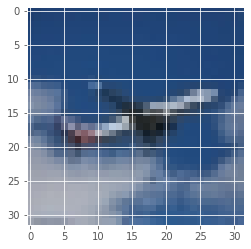

In [62]:
image = plt.imread('plane_32.jpg')

plt.imshow(image)

In [ ]:
#keras.models.save_model('model_cnn.h5')

In [63]:
image = image.astype('float32')

image /= 255

image = image[None, :, :, :]
image.shape

(1, 32, 32, 3)

In [69]:
from tensorflow import keras
reconstructed_model = keras.models.load_model("model_cnn.h5", compile=False)

In [70]:
prediction = reconstructed_model.predict(image)

pred_class = np.argmax(prediction)

print(cat_dict[pred_class])

Plane
